In [1]:
#	Emotion recognition from faces	Data augmentation, dropout	FER2013 or custom

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from PIL import Image

In [3]:
test_transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5],std=[0.5])])
train_transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5],std=[0.5])])
train_dataset=torchvision.datasets.FER2013(root='./data',split='train',transform=train_transform)
test_dataset=torchvision.datasets.FER2013(root='./data',transform=test_transform,split='test')
train_loaders=DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)
test_loaders=DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=2)

In [7]:
class Emotionrecognition(nn.Module):
    def __init__(self, hidden_size,output_size):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1)
        self.bn1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 48, 48)  # adjust to your input size
            out = self.pool(F.relu(self.bn2(self.conv2(self.pool(F.relu(self.bn1(self.conv1(dummy))))))))
            self.flattened_size = out.numel()
        self.fc1=nn.Linear(self.flattened_size,hidden_size)
        self.fc2=nn.Linear(hidden_size,output_size)
    def forward(self,X):
        X=self.pool(F.relu(self.bn1(self.conv1(X))))
        X=self.pool(F.relu(self.bn2(self.conv2(X))))
        X=torch.flatten(X,start_dim=1)
        X=F.relu(self.fc1(X))
        X=self.fc2(X)
        return X

In [8]:
hidden_size=64
output_size=7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Emotionrecognition(hidden_size,output_size).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [9]:
no_epochs=30
model.train()
for epochs in range(no_epochs):
    running_loss=0
    for inputs,labels in train_loaders:
        outputs=model(inputs)
        optimizer.zero_grad()
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    average_loss=running_loss/len(train_loaders)
    print(f"epoch {epochs+1},loss:{average_loss}")



epoch 1,loss:1.6065525573186725
epoch 2,loss:1.4167536242236538
epoch 3,loss:1.3558573730804342
epoch 4,loss:1.3162073550086244
epoch 5,loss:1.2836036966213404
epoch 6,loss:1.2613984545514418
epoch 7,loss:1.2424451961018195
epoch 8,loss:1.2199205572992762
epoch 9,loss:1.2046669866300639
epoch 10,loss:1.1830913999298367
epoch 11,loss:1.1711909149696673
epoch 12,loss:1.1604865319479283
epoch 13,loss:1.144845767780508
epoch 14,loss:1.1323167660454068
epoch 15,loss:1.1219268802279618
epoch 16,loss:1.106837451590727
epoch 17,loss:1.1029899261045562
epoch 18,loss:1.0956927103826357
epoch 19,loss:1.0890583053463552
epoch 20,loss:1.0809234881188663
epoch 21,loss:1.0770850570536403
epoch 22,loss:1.0656193162922338
epoch 23,loss:1.0604838947941837
epoch 24,loss:1.056705453746303
epoch 25,loss:1.0419189377723133
epoch 26,loss:1.046192883515942
epoch 27,loss:1.0301548619578305
epoch 28,loss:1.035512013929193
epoch 29,loss:1.0284030866251226
epoch 30,loss:1.0209931625024247


In [10]:
torch.save(model.state_dict(), 'cifar10_classifier.pth')
print("✅ Model saved as 'cifar10_classifier.pth'")

✅ Model saved as 'cifar10_classifier.pth'


In [11]:
model.eval()
with torch.no_grad():
    total=0
    correct=0
    for inputs,labels in test_loaders:
        outputs=model(inputs)
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    accuracy=100*correct/total
    print(f"accuracy:{accuracy}%")





accuracy:57.815547506269155%


In [12]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),      # convert to 1-channel
    transforms.Resize((48, 48)),                      # resize to FER size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])       # same as training
])

img_path = "C:/Users/LENOVO/Downloads/emotionrecognition.jpg" # replace with your image path
img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0)  # shape = [1, 1, 48, 48]


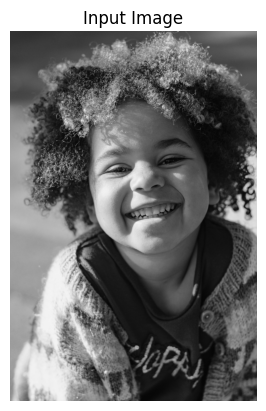

Predicted Emotion: Happy


In [13]:
original_image=Image.open(img_path).convert('L')
plt.imshow(original_image,cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = emotion_labels[predicted.item()]
print(f"Predicted Emotion: {predicted_class}") 